In [1]:
from utilities import *
from mk_test import mk_test

In [2]:
class MK_Flows(Flows):

    
    def _create_huc_full_timeseries(self):
        huc = pd.DataFrame()
        for projection in PROJECTIONS:
            for policy in self.all_flow_scenarios[projection].columns:
                huc[policy] = self.historical_uncontrolled_timeseries['00']
            self.all_flow_scenarios[projection] =  pd.concat([huc, self.all_flow_scenarios[projection]])

    def run_test(self):
        self._create_huc_full_timeseries()
        self.mk_results = dict.fromkeys(PROJECTIONS)
        for projection in PROJECTIONS:
            self.mk_results[projection] = dict.fromkeys(ROBUST_POLICY_LIST)
            for policy in ROBUST_POLICY_LIST:
                trend, _, p, _ = mk_test(np.array(self.all_flow_scenarios[projection][policy]))
                self.mk_results[projection][policy] = {
                    "trend": trend,
                    "p": p
                }

    def calc_stats(self):
        self.mk_trend_projections = dict.fromkeys(ROBUST_POLICY_LIST)
        self.mk_policy_percents = dict.fromkeys(ROBUST_POLICY_LIST)
        for policy in ROBUST_POLICY_LIST:
            self.mk_trend_projections[policy] = {
                "No Trend": [],
                "Increasing": [],
                "Decreasing": [],
            }
            self.mk_policy_percents[policy] = {
                "No Trend": [],
                "Increasing": [],
                "Decreasing": [],            
            }
        
        for projection in PROJECTIONS:
            for policy in ROBUST_POLICY_LIST:
                if self.mk_results[projection][policy]['trend'] == 'no trend':
                    self.mk_trend_projections[policy]['No Trend'].append(projection)
                elif self.mk_results[projection][policy]['trend'] == 'increasing':
                    self.mk_trend_projections[policy]['Increasing'].append(projection)
                else:
                    self.mk_trend_projections[policy]['Decreasing'].append(projection)
        
        self.trend_plot_data = pd.DataFrame(columns=['Scenario', 'No Trend', 'Increasing', 'Decreasing'])
            
        for policy in ROBUST_POLICY_LIST:
            self.mk_policy_percents[policy]['Scenario'] =  list(ROBUST_POLICIES.keys())[list(ROBUST_POLICIES.values()).index(policy)]
            self.mk_policy_percents[policy]["No Trend"] = len(self.mk_trend_projections[policy]['No Trend']) / len(PROJECTIONS)
            self.mk_policy_percents[policy]["Increasing"] = len(self.mk_trend_projections[policy]['Increasing']) / len(PROJECTIONS)
            self.mk_policy_percents[policy]["Decreasing"] = len(self.mk_trend_projections[policy]['Decreasing']) / len(PROJECTIONS)
            
            temp_df = pd.DataFrame(self.mk_policy_percents[policy], index=[0])
            
            self.trend_plot_data = pd.concat([self.trend_plot_data, temp_df]).reset_index(drop=True)
            
        lst = ['Compromise', 'High Flow', 'Low Flow', "PUC"]        
        self.trend_plot_data.set_index('Scenario', inplace=True)
        self.trend_plot_data = self.trend_plot_data.loc[lst]


            

In [3]:
low_flows = MK_Flows("7Q", 'Unnamed: 0', HUC_7Q)
high_flows = MK_Flows("AMS", 'date', HUC_AMS)

In [4]:
low_flows.run_test()
high_flows.run_test()

In [5]:
low_flows.calc_stats()
high_flows.calc_stats()

In [8]:
with open("results/high_flow_trends.json", "w") as outfile:
    json.dump(high_flows.mk_trend_projections, outfile)

In [9]:
with open("results/low_flow_trends.json", "w") as outfile:
    json.dump(low_flows.mk_trend_projections, outfile)

In [41]:
high_flows.trend_plot_data

,No Trend,Increasing,Decreasing
Scenario,,,
Compromise,0.437500,0.270833,0.291667
High Flow,0.583333,0.166667,0.250000
Low Flow,0.479167,0.125000,0.395833
PUC,0.229167,0.687500,0.083333


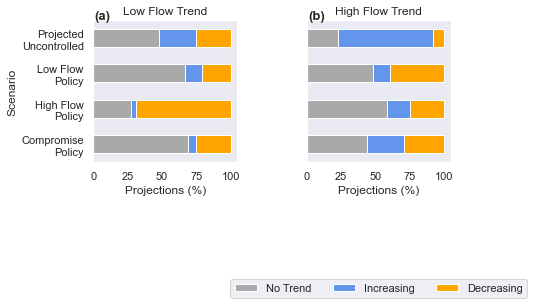

In [19]:
import seaborn as sns
import string
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2)
sns.set(style="dark")
low_flows.trend_plot_data.plot(kind="barh", stacked=True, color=['darkgrey', 'cornflowerblue', 'orange'], ax = ax1, legend = False)
high_flows.trend_plot_data.plot(kind="barh", stacked=True, color=['darkgrey', 'cornflowerblue', 'orange'], ax = ax2, legend=True)
for (ax,i) in zip([ax1, ax2], range(2)):
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0, 25, 50, 75, 100])
    ax.set_xlabel("Projections (%)")
    ax.text(0.008, 1.01, "("+ string.ascii_lowercase[i] + ")", transform=ax.transAxes, 
        size=13, weight='bold')
ax2.set_yticklabels("")
ax2.set_ylabel("")
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -1),
          ncol=3)
ax1.set_title("Low Flow Trend")
ax2.set_title("High Flow Trend")
ax1.set_yticklabels(['Compromise\nPolicy', 
                     'High Flow\nPolicy',
                     'Low Flow\nPolicy',
                     'Projected\nUncontrolled'])
fig.set_size_inches([7.3, 10])
fig.tight_layout()
plt.savefig("Figures/MannKendall-Legend.png")
plt.savefig("Figures/MannKendall-Legend.svg")
plt.savefig("Figures/MannKendall-Legend.pdf")

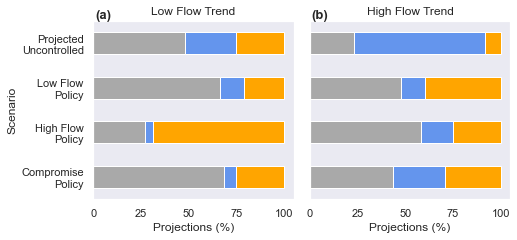

In [20]:
import seaborn as sns
import string
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2)
sns.set(style="dark")
low_flows.trend_plot_data.plot(kind="barh", stacked=True, color=['darkgrey', 'cornflowerblue', 'orange'], ax = ax1, legend = False)
high_flows.trend_plot_data.plot(kind="barh", stacked=True, color=['darkgrey', 'cornflowerblue', 'orange'], ax = ax2, legend=False)
for (ax,i) in zip([ax1, ax2], range(2)):
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0, 25, 50, 75, 100])
    ax.set_xlabel("Projections (%)")
    ax.text(0.008, 1.01, "("+ string.ascii_lowercase[i] + ")", transform=ax.transAxes, 
        size=13, weight='bold')
ax2.set_yticklabels("")
ax2.set_ylabel("")
# ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -1),
#           ncol=3)
ax1.set_title("Low Flow Trend")
ax2.set_title("High Flow Trend")
ax1.set_yticklabels(['Compromise\nPolicy', 
                     'High Flow\nPolicy',
                     'Low Flow\nPolicy',
                     'Projected\nUncontrolled'])
fig.set_size_inches([7.35, 3.5])
fig.tight_layout()
plt.savefig("Figures/MannKendall.png")
plt.savefig("Figures/MannKendall.svg")
plt.savefig("Figures/MannKendall.pdf")